This notebook analyzes scaling laws when learning on top of frozen embeddings.

It is based off of `notebooks/hf-transfer/probe-scaling.ipynb`. It has the added capability of modeling the embedding distribution with a Gaussian mixture model.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import dataclasses
import pathlib
import sys

import cuml.neighbors.kneighbors_classifier
import git.repo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm

GIT_ROOT = pathlib.Path(
    str(git.repo.Repo(".", search_parent_directories=True).working_tree_dir)
)
sys.path.append(str(GIT_ROOT))

from src.pretrain import gen_embeddings, probe_embeddings
from src.pretrain.datasets.embedding import EmbeddingDataset
from src.pretrain.datasets.vision import cifar10, imagenette, svhn
from src.pretrain.models.vision import laion_clip, msft_beit, openai_clip

### Load data

In [22]:
dataset_cfg = cifar10.CIFAR10()
# embedder_cfg = openai_clip.OpenaiClipConfig(id="openai/ViT-L/14@336px")
# embedder_cfg = laion_clip.LaionClipConfig(id="hf/laion/CLIP-ViT-H-14-laion2B-s32B-b79K")
embedder_cfg = msft_beit.MsftBeitConfig(
    id="hf/microsoft/beit-large-patch16-224-pt22k"
)

embedding_cfg = gen_embeddings.Config(
    dataset_cfg=dataset_cfg,
    embedder_cfg=embedder_cfg,
)
probe_cfg = probe_embeddings.Config(
    embedder_cfg=embedder_cfg,
    dataset_cfg=dataset_cfg,
)

DS = EmbeddingDataset.load_from_file(embedding_cfg.full_save_path).astype(
    np.float32
)
DS.xs_train.shape, DS.xs_test.shape, DS.xs_test.dtype

((50000, 1024), (10000, 1024), dtype('float32'))

### Dataset info

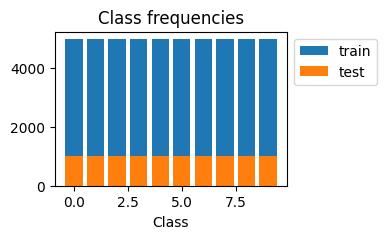

In [23]:
fig = probe_embeddings.plot_class_frequencies(DS)
fig.set_size_inches(w=3, h=2)

### Fit gaussian proxy model to data

In [24]:
def get_gaussian_proxy(
    ds: EmbeddingDataset,
    with_label_noise: bool = False,
) -> EmbeddingDataset:
    """
    Get a GMM proxy for ds.
    Will use both ds.train and ds.test to fit the GMM.

    If with_label_noise is True, then some labels will be shuffled according to
    the empirical frequency of shuffled labels in ds.
    """

    xs = np.concatenate([ds.xs_train, ds.xs_test])
    ys = np.concatenate([ds.ys_train, ds.ys_test])

    uys = np.unique(ys)
    mus = np.zeros((len(uys), xs.shape[1]))
    covs = np.zeros((len(uys), xs.shape[1], xs.shape[1]))

    ret_ds = copy.deepcopy(ds)
    for i, y in enumerate(uys):
        # Compute sample mean and covariance for class y
        mask = ys == y
        mu = xs[mask].mean(axis=0)
        cov = np.cov(xs[mask].T)

        # Save mu and cov
        mus[i] = mu
        covs[i] = cov

        # Sample from the Gaussian and save to ret_ds
        mask_train = ds.ys_train == y
        mask_test = ds.ys_test == y
        ret_ds.xs_train[mask_train] = np.random.multivariate_normal(
            mean=mu, cov=cov, size=mask_train.sum()
        )
        ret_ds.xs_test[mask_test] = np.random.multivariate_normal(
            mean=mu, cov=cov, size=mask_test.sum()
        )

    if with_label_noise:
        # Fit a 3-nearest neighbor classifier to (xs, ys)
        clf = cuml.neighbors.kneighbors_classifier.KNeighborsClassifier(
            n_neighbors=3,
            weights="uniform",
            metric="euclidean",
        )
        clf.fit(xs, ys)

        # Get knn predictions
        knn_preds = clf.predict(xs)
        knn_preds_train = knn_preds[: len(ds.ys_train)]
        knn_preds_test = knn_preds[len(ds.ys_train) :]

        # Resample points in ret_ds where we have a knn prediction mismatch
        for i, y in enumerate(uys):
            mask_train = (knn_preds_train == y) & (ds.ys_train != y)
            mask_test = (knn_preds_test == y) & (ds.ys_test != y)

            ret_ds.xs_train[mask_train] = np.random.multivariate_normal(
                mean=mus[i], cov=covs[i], size=mask_train.sum()
            )
            ret_ds.xs_test[mask_test] = np.random.multivariate_normal(
                mean=mus[i], cov=covs[i], size=mask_test.sum()
            )

    return ret_ds


ds_gmm = get_gaussian_proxy(DS)
ds_gmm_noised = get_gaussian_proxy(DS, with_label_noise=True)

### Visualize embeddings with UMAP

In [25]:
fig = probe_embeddings.plot_umap(DS, cfg=probe_cfg)
fig.update_layout(
    width=600,
    height=300,
)
fig.show()

fig = probe_embeddings.plot_umap(ds_gmm, cfg=probe_cfg)
fig.update_layout(
    width=600,
    height=300,
)
fig.show()

fig = probe_embeddings.plot_umap(ds_gmm_noised, cfg=probe_cfg)
fig.update_layout(
    width=600,
    height=300,
)
fig.show()

### Get scaling data

In [26]:
%%capture
df = probe_embeddings.get_scaling_results(
    ds=DS,
    cfg=dataclasses.replace(
        probe_cfg, n_classes=(10,), cs=(100,), ks=(1,)
    ),
)

In [27]:
%%capture
df_gmm = probe_embeddings.get_scaling_results(
    ds=ds_gmm,
    cfg=dataclasses.replace(
        probe_cfg, n_classes=(10,), cs=(100,), ks=(1,)
    ),
)

In [28]:
%%capture
df_gmm_noised = probe_embeddings.get_scaling_results(
    ds=ds_gmm_noised,
    cfg=dataclasses.replace(
        probe_cfg, n_classes=(10,), cs=(100,), ks=(1,)
    ),
)

### Plot scaling data

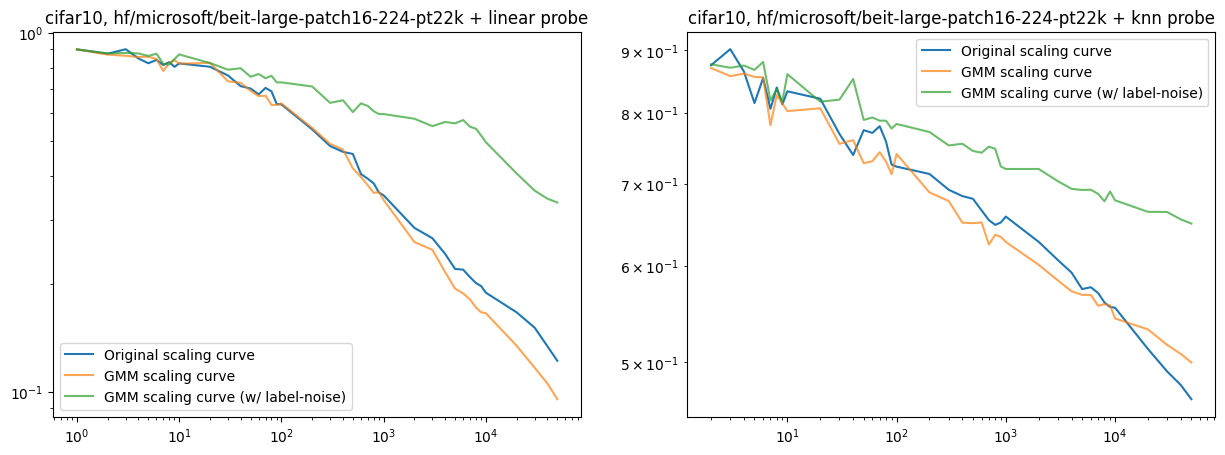

In [29]:
plt.figure(figsize=(15, 5))
for i, probe_type in enumerate(("linear", "knn")):
    plt.subplot(1, 2, i + 1)

    cdf = df.query(f"probe == '{probe_type}' & ~per_class").sort_values(
        "n_train"
    )
    plt.plot(cdf.n_train, cdf.err, label="Original scaling curve")

    cdf = df_gmm.query(f"probe == '{probe_type}' & ~per_class").sort_values(
        "n_train"
    )
    plt.plot(cdf.n_train, cdf.err, label="GMM scaling curve", alpha=0.7)

    cdf = df_gmm_noised.query(
        f"probe == '{probe_type}' & ~per_class"
    ).sort_values("n_train")
    plt.plot(
        cdf.n_train,
        cdf.err,
        label="GMM scaling curve (w/ label-noise)",
        alpha=0.7,
    )

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.title(
        f"{probe_cfg.dataset_cfg.id}, {probe_cfg.embedder_cfg.id} + {probe_type} probe"
    )